# Question 3

Importing required libraries - `numpy`, `matplotlib`, `torch`, `torchvision`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

Importing miscellaneous libraries - `time`, `os`, `torchsummary`

In [2]:
import time
import os
from torchsummary import summary

## Preparing the dataset

Downloading FashionMNIST train dataset from `torchvision` library.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data = datasets.FashionMNIST(root='./data/', download=True, train=True, transform=transform)

Getting the size of the dataset

In [4]:
print("Dataset Size :", len(data))

Dataset Size : 60000


Creating an iterable DataLoader for our dataset

We set the batch size for our DataLoader as 32

In [5]:
batch_size = 32

In [6]:
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Visualizing a few samples from training_data

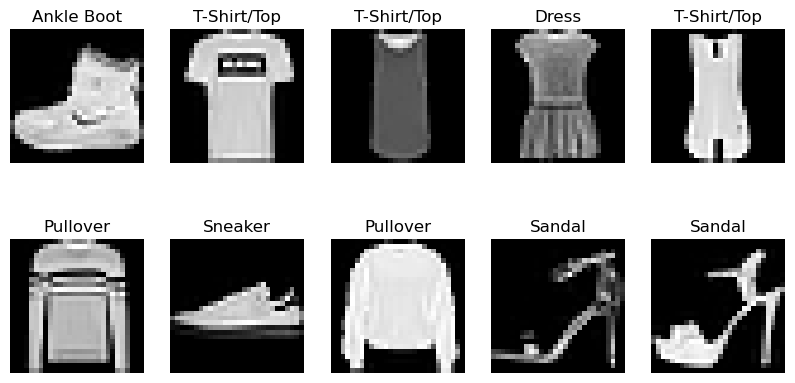

In [7]:
labels_map = {
    0: "T-Shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}
plt.figure(figsize=(10, 5))
for index in np.arange(0, 10):
  image, label = data[index]
  plt.subplot(2, 5, index + 1)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(image.squeeze().numpy(), cmap=plt.cm.gray)

To seamlessly use a GPU, if one is available, we set our `device` variable

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Network Architecture

Now, setting up the architecture of our DCGAN

### Generator Architecture

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.dense = nn.Linear(100, 7*7*256, bias=False)
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.3)

    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, 256, 7, 7)
        x = self.leaky_relu(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        
        x = self.conv3(x)
        x = self.tanh(x)
        
        return x

In [10]:
generator = Generator()

In [11]:
summary(generator, (100,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 12544]               1,254,400
├─LeakyReLU: 1-2                         [-1, 256, 7, 7]           --
├─ConvTranspose2d: 1-3                   [-1, 128, 7, 7]           819,200
├─BatchNorm2d: 1-4                       [-1, 128, 7, 7]           256
├─LeakyReLU: 1-5                         [-1, 128, 7, 7]           --
├─ConvTranspose2d: 1-6                   [-1, 64, 14, 14]          204,800
├─BatchNorm2d: 1-7                       [-1, 64, 14, 14]          128
├─LeakyReLU: 1-8                         [-1, 64, 14, 14]          --
├─ConvTranspose2d: 1-9                   [-1, 1, 28, 28]           1,600
├─Tanh: 1-10                             [-1, 1, 28, 28]           --
Total params: 2,280,384
Trainable params: 2,280,384
Non-trainable params: 0
Total mult-adds (M): 82.79
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 8.70
Estimated Total S

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 12544]               1,254,400
├─LeakyReLU: 1-2                         [-1, 256, 7, 7]           --
├─ConvTranspose2d: 1-3                   [-1, 128, 7, 7]           819,200
├─BatchNorm2d: 1-4                       [-1, 128, 7, 7]           256
├─LeakyReLU: 1-5                         [-1, 128, 7, 7]           --
├─ConvTranspose2d: 1-6                   [-1, 64, 14, 14]          204,800
├─BatchNorm2d: 1-7                       [-1, 64, 14, 14]          128
├─LeakyReLU: 1-8                         [-1, 64, 14, 14]          --
├─ConvTranspose2d: 1-9                   [-1, 1, 28, 28]           1,600
├─Tanh: 1-10                             [-1, 1, 28, 28]           --
Total params: 2,280,384
Trainable params: 2,280,384
Non-trainable params: 0
Total mult-adds (M): 82.79
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 8.70
Estimated Total S

In [12]:
generator =  generator.to(device)

if device == 'cuda':
    generator = torch.nn.DataParallel(generator)
    cudnn.benchmark = True

### Discriminator Architecture

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(128*7*7, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.flatten(x)
        x = self.dense(x)
        
        return x

In [14]:
discriminator = Discriminator()

In [15]:
summary(discriminator, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 14, 14]          1,664
├─LeakyReLU: 1-2                         [-1, 64, 14, 14]          --
├─Dropout: 1-3                           [-1, 64, 14, 14]          --
├─Conv2d: 1-4                            [-1, 128, 7, 7]           204,928
├─LeakyReLU: 1-5                         [-1, 128, 7, 7]           --
├─Dropout: 1-6                           [-1, 128, 7, 7]           --
├─Flatten: 1-7                           [-1, 6272]                --
├─Linear: 1-8                            [-1, 1]                   6,273
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
Total mult-adds (M): 10.36
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.81
Estimated Total Size (MB): 0.96


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 14, 14]          1,664
├─LeakyReLU: 1-2                         [-1, 64, 14, 14]          --
├─Dropout: 1-3                           [-1, 64, 14, 14]          --
├─Conv2d: 1-4                            [-1, 128, 7, 7]           204,928
├─LeakyReLU: 1-5                         [-1, 128, 7, 7]           --
├─Dropout: 1-6                           [-1, 128, 7, 7]           --
├─Flatten: 1-7                           [-1, 6272]                --
├─Linear: 1-8                            [-1, 1]                   6,273
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
Total mult-adds (M): 10.36
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.81
Estimated Total Size (MB): 0.96

In [16]:
discriminator =  discriminator.to(device)

if device == 'cuda':
    discriminator = torch.nn.DataParallel(discriminator)
    cudnn.benchmark = True

## Model Training

Helper function to format epoch runtime

In [17]:
def format_time(seconds):
  days = int(seconds / 3600/24)
  seconds = seconds - days*3600*24
  hours = int(seconds / 3600)
  seconds = seconds - hours*3600
  minutes = int(seconds / 60)
  seconds = seconds - minutes*60
  secondsf = int(seconds)
  seconds = seconds - secondsf
  millis = int(seconds*1000)

  f = ''
  i = 1
  if days > 0:
    f += str(days) + 'D'
    i += 1
  if hours > 0 and i <= 2:
    f += str(hours) + 'h'
    i += 1
  if minutes > 0 and i <= 2:
    f += str(minutes) + 'm'
    i += 1
  if secondsf > 0 and i <= 2:
    f += str(secondsf) + 's'
    i += 1
  if millis > 0 and i <= 2:
    f += str(millis) + 'ms'
    i += 1
  if f == '':
    f = '0ms'
  return f

Initializing the learning rate, epochs, optimizers and loss functions

In [18]:
lr = 1e-4

epochs = 50

criterion = nn.BCEWithLogitsLoss()

generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [19]:
def train(epochs):
    show_image_at_epochs = [1, 10, 30, 50]

    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        start_time = time.time()

        generator.train()
        discriminator.train()

        generator_epoch_loss = 0.0
        discriminator_epoch_loss = 0.0

        for real_images, _ in dataloader:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Training the discriminator
            discriminator_optimizer.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            
            real_output = discriminator(real_images)
            real_loss = criterion(real_output, real_labels)

            noise = torch.randn(batch_size, 100).to(device)
            fake_images = generator(noise)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            fake_output = discriminator(fake_images.detach())
            fake_loss = criterion(fake_output, fake_labels)
            
            discriminator_loss = real_loss + fake_loss

            discriminator_loss.backward()
            discriminator_optimizer.step()
            
            discriminator_epoch_loss += discriminator_loss.item() * batch_size

            # Training the generator
            generator_optimizer.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            
            noise = torch.randn(batch_size, 100).to(device)
            fake_images = generator(noise)
            fake_output = discriminator(fake_images)
            generator_loss = criterion(fake_output, real_labels)
            
            generator_loss.backward()
            generator_optimizer.step()

            generator_epoch_loss += generator_loss.item() * batch_size
            

        discriminator_epoch_loss /= len(dataloader.dataset)
        discriminator_losses.append(discriminator_epoch_loss)
        
        generator_epoch_loss /= len(dataloader.dataset)
        generator_losses.append(generator_epoch_loss)

        cur_time = time.time()
        epoch_time = cur_time - start_time
        print(f"Epoch ({epoch + 1}/{epochs})")
        print(f"Training Time : {format_time(epoch_time)}")
        print(f"Generator Loss : {generator_epoch_loss:.4f} | Discriminator Loss : {discriminator_epoch_loss:.4f}")
        print("")

        if (epoch + 1) in show_image_at_epochs:
            with torch.no_grad():
                noise = torch.randn(16, 100).to(device)
                fake_images = generator(noise)
                fake_images = vutils.make_grid(fake_images, nrow=4, normalize=True)
                plt.figure(figsize=(8, 8))
                plt.axis("off")
                plt.title(f"Generated Images at Epoch {epoch + 1}")
                plt.imshow(fake_images.permute(1, 2, 0).detach().cpu().numpy())
                plt.show()

    return generator_losses, discriminator_losses

Epoch (1/50)
Training Time : 13s162ms
Generator Loss : 0.8997 | Discriminator Loss : 1.2583



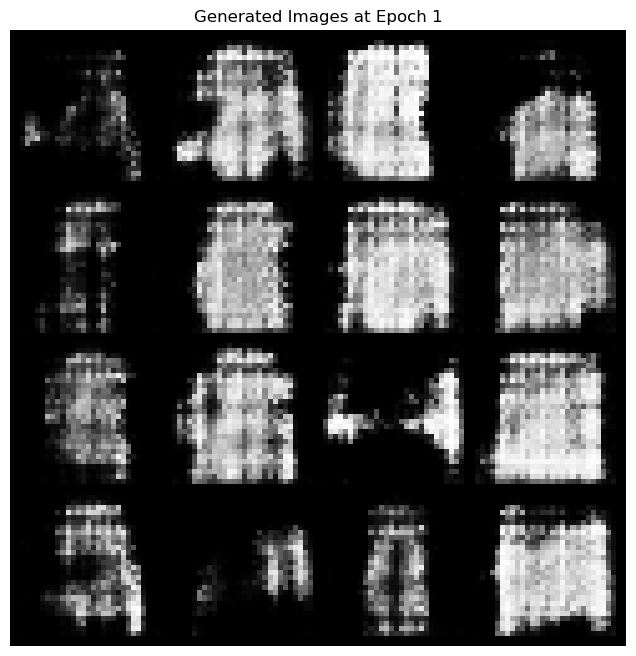

Epoch (2/50)
Training Time : 11s958ms
Generator Loss : 0.8803 | Discriminator Loss : 1.2361

Epoch (3/50)
Training Time : 11s900ms
Generator Loss : 0.8444 | Discriminator Loss : 1.2695

Epoch (4/50)
Training Time : 11s957ms
Generator Loss : 0.8403 | Discriminator Loss : 1.2753

Epoch (5/50)
Training Time : 11s935ms
Generator Loss : 0.8310 | Discriminator Loss : 1.2865

Epoch (6/50)
Training Time : 11s915ms
Generator Loss : 0.8210 | Discriminator Loss : 1.2963

Epoch (7/50)
Training Time : 11s848ms
Generator Loss : 0.8169 | Discriminator Loss : 1.2981

Epoch (8/50)
Training Time : 11s904ms
Generator Loss : 0.8198 | Discriminator Loss : 1.2997

Epoch (9/50)
Training Time : 11s890ms
Generator Loss : 0.8230 | Discriminator Loss : 1.2974

Epoch (10/50)
Training Time : 11s833ms
Generator Loss : 0.8207 | Discriminator Loss : 1.2955



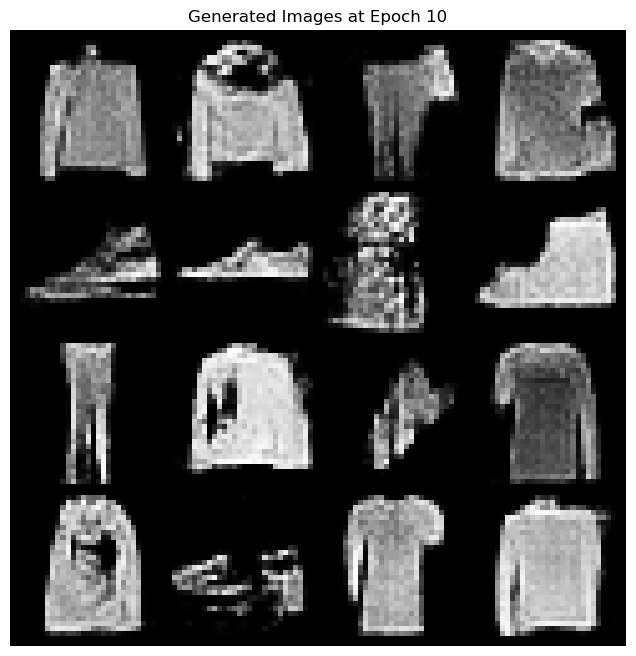

Epoch (11/50)
Training Time : 11s861ms
Generator Loss : 0.8207 | Discriminator Loss : 1.2988

Epoch (12/50)
Training Time : 11s931ms
Generator Loss : 0.8229 | Discriminator Loss : 1.2984

Epoch (13/50)
Training Time : 11s855ms
Generator Loss : 0.8253 | Discriminator Loss : 1.2990

Epoch (14/50)
Training Time : 11s869ms
Generator Loss : 0.8246 | Discriminator Loss : 1.2971

Epoch (15/50)
Training Time : 11s825ms
Generator Loss : 0.8291 | Discriminator Loss : 1.2938

Epoch (16/50)
Training Time : 11s907ms
Generator Loss : 0.8291 | Discriminator Loss : 1.2949

Epoch (17/50)
Training Time : 11s825ms
Generator Loss : 0.8315 | Discriminator Loss : 1.2938

Epoch (18/50)
Training Time : 11s921ms
Generator Loss : 0.8309 | Discriminator Loss : 1.2953

Epoch (19/50)
Training Time : 11s927ms
Generator Loss : 0.8318 | Discriminator Loss : 1.2954

Epoch (20/50)
Training Time : 11s895ms
Generator Loss : 0.8314 | Discriminator Loss : 1.2963

Epoch (21/50)
Training Time : 11s833ms
Generator Loss : 0.83

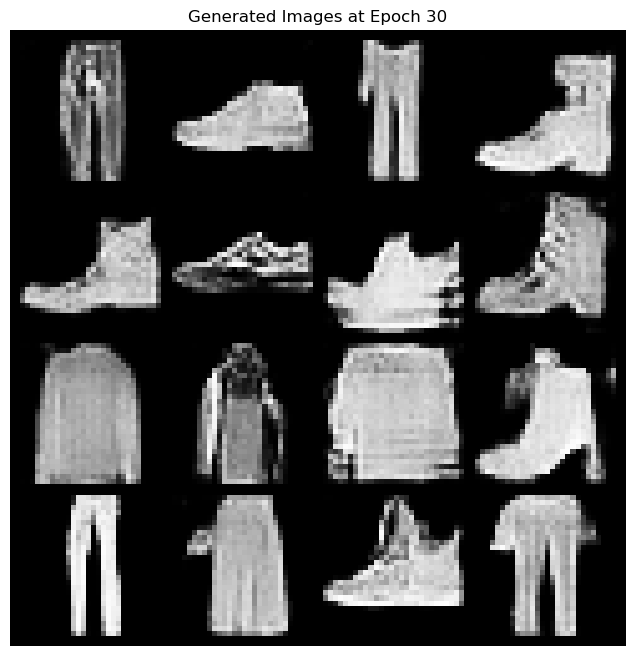

Epoch (31/50)
Training Time : 11s848ms
Generator Loss : 0.8287 | Discriminator Loss : 1.3027

Epoch (32/50)
Training Time : 11s847ms
Generator Loss : 0.8263 | Discriminator Loss : 1.3020

Epoch (33/50)
Training Time : 11s844ms
Generator Loss : 0.8294 | Discriminator Loss : 1.3048

Epoch (34/50)
Training Time : 11s869ms
Generator Loss : 0.8269 | Discriminator Loss : 1.3022

Epoch (35/50)
Training Time : 11s836ms
Generator Loss : 0.8292 | Discriminator Loss : 1.3045

Epoch (36/50)
Training Time : 11s853ms
Generator Loss : 0.8289 | Discriminator Loss : 1.3040

Epoch (37/50)
Training Time : 11s865ms
Generator Loss : 0.8256 | Discriminator Loss : 1.3056

Epoch (38/50)
Training Time : 11s847ms
Generator Loss : 0.8261 | Discriminator Loss : 1.3051

Epoch (39/50)
Training Time : 12s404ms
Generator Loss : 0.8262 | Discriminator Loss : 1.3061

Epoch (40/50)
Training Time : 11s912ms
Generator Loss : 0.8269 | Discriminator Loss : 1.3050

Epoch (41/50)
Training Time : 11s870ms
Generator Loss : 0.82

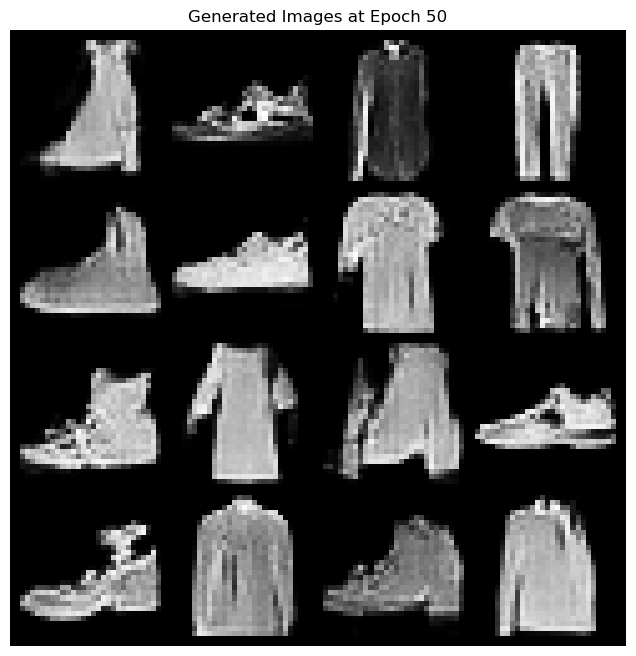

In [20]:
generator_losses, discriminator_losses = train(epochs)

Text(0.5, 1.0, 'Loss vs. No. of epochs')

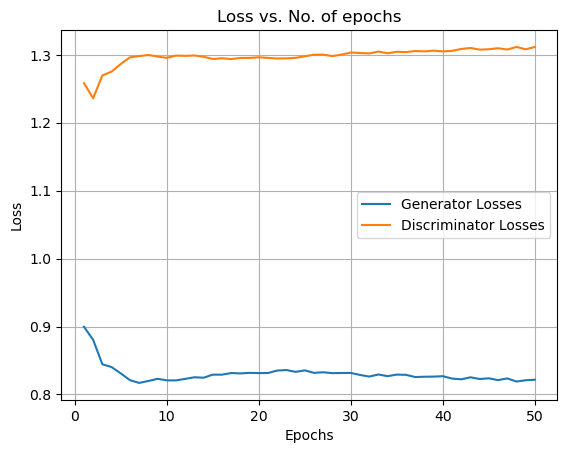

In [21]:
plt.plot(range(1, epochs + 1), generator_losses, label='Generator Losses')
plt.plot(range(1, epochs + 1), discriminator_losses, label='Discriminator Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [22]:
state = {
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'generator_losses': generator_losses,
    'discriminator_losses': discriminator_losses,
    'epochs': epochs,
}

if not os.path.isdir('models'):
    os.mkdir('models')

torch.save(state, './models/dcgan.pth')